In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline

In [14]:
# Cargar datos de pacientes hospitalizados por día (ya procesados)
daily_counts = pd.read_csv("./data/daily_hospitalized_patients.csv")
# Parsear fechas
daily_counts['date'] = pd.to_datetime(daily_counts['date'])

# Cargar datos climáticos
df_weather = pd.read_csv("./data/HDHI_pollution_data.csv")

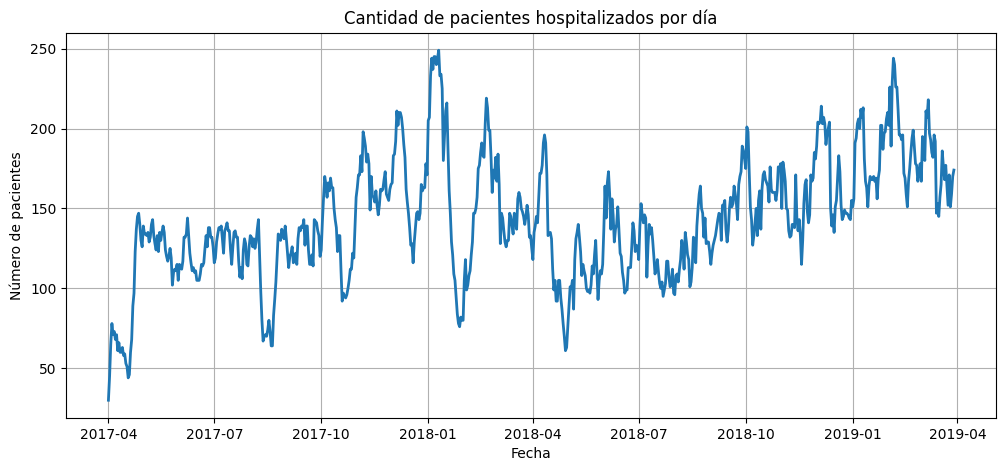

In [15]:
# Visualizar serie temporal de pacientes hospitalizados por día
plt.figure(figsize=(12,5))
plt.plot(daily_counts['date'], daily_counts['num_patients'], linewidth=2)
plt.title('Cantidad de pacientes hospitalizados por día')
plt.xlabel('Fecha')
plt.ylabel('Número de pacientes')
plt.grid(True)
plt.show()

In [16]:
# Procesar datos climáticos
df_weather['DATE'] = pd.to_datetime(df_weather['DATE'], errors='coerce', dayfirst=True)

# Seleccionamos variables numéricas relevantes
weather_vars = [
    'PM2.5 AVG', 'PM10 AVG', 'NO2 AVG', 'OZONE AVG',
    'MAX TEMP', 'MIN TEMP', 'HUMIDITY'
]
df_weather = df_weather[['DATE'] + weather_vars].dropna()

# Unir datasets
df = pd.merge(daily_counts, df_weather, left_on='date', right_on='DATE', how='inner').drop(columns=['DATE'])


C:\Users\Gaby\AppData\Local\Temp\ipykernel_22140\2046202766.py:2: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df_weather['DATE'] = pd.to_datetime(df_weather['DATE'], errors='coerce', dayfirst=True)


In [17]:
df.head()

,date,num_patients,PM2.5 AVG,PM10 AVG,NO2 AVG,OZONE AVG,MAX TEMP,MIN TEMP,HUMIDITY
0,2017-04-01,30,38,35,20,44,40,24,16.0
1,2017-04-02,45,53,59,18,40,40,21,14.0
2,2017-04-03,65,62,70,10,47,39,22,14.0
3,2017-04-04,78,70,63,12,50,39,23,23.0
4,2017-04-05,71,88,85,6,40,36,20,51.0


In [18]:
# Crear variables de rezago (lags)
for lag in range(1, 8):  # memoria de 7 días
    df[f'lag_{lag}'] = df['num_patients'].shift(lag)

df = df.dropna().reset_index(drop=True)


In [19]:
# Variables predictoras y target
feature_cols = [col for col in df.columns if col not in ['date', 'num_patients']]
X = df[feature_cols]
y = df['num_patients']

# División temporal train/test
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [20]:
# Pipeline Random Forest
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ))
])

# Entrenamiento
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 RandomForestRegressor(max_depth=10, min_samples_leaf=2,
                                       min_samples_split=5, n_jobs=-1,
                                       random_state=42))])

MAE: 11.64
R²: 0.654


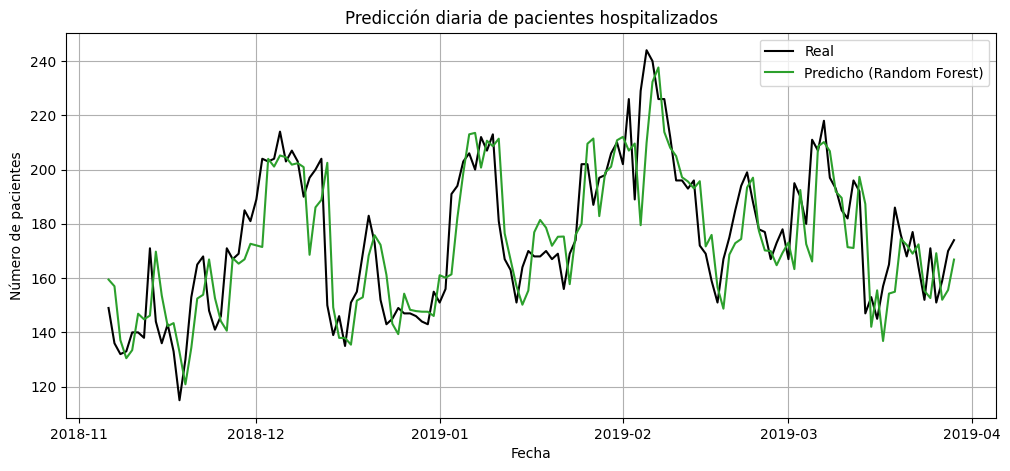

In [21]:
# Evaluación
y_pred = rf_pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")

# Visualización
plt.figure(figsize=(12,5))
plt.plot(df['date'].iloc[split_idx:], y_test.values, label='Real', color='black')
plt.plot(df['date'].iloc[split_idx:], y_pred, label='Predicho (Random Forest)', color='tab:green')
plt.title('Predicción diaria de pacientes hospitalizados')
plt.xlabel('Fecha')
plt.ylabel('Número de pacientes')
plt.legend()
plt.grid(True)
plt.show()
